MSRFuseNet - Preprocessing - DWT(3 Features) - NORMAL - 39 

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, DWT features per epoch: 15
Valid epochs after masking: 45885


C:\Users\DST\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0           ['ppg_input[0][0]']              
                                                                                                  
 separable_conv1d (SeparableCon  (None, 1024, 32)    79          ['gaussian_noise[0][0]']         
 v1D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['separable_conv1d[0][0]']   

 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 32)      0           ['max_pooling1d_1[0][0]',        
                                                                  'average_pooling1d[0][0]']      
                                                                                                  
 add_1 (Add)                    (None, 256, 32)      0           ['batch_normalization_9[0][0]',  
                                                                  'tf.math.subtract[0][0]']       
          

 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8224)         0           ['flatten[0][0]',                
                                                                  'batch_normalization_14[0][0]'] 
                                                                                                  
 dense_6 (Dense)                (None, 64)           526400      ['concatenate_1[0][0]']          
                                                                                                  
 batch_nor

Epoch 36/100
2072/2072 [==============================] - 172s 83ms/step - loss: 0.3905 - accuracy: 0.7248 - val_loss: 0.4288 - val_accuracy: 0.7108 - lr: 2.0000e-04
Epoch 37/100
2072/2072 [==============================] - 175s 84ms/step - loss: 0.3876 - accuracy: 0.7274 - val_loss: 0.4285 - val_accuracy: 0.7098 - lr: 2.0000e-04
Epoch 38/100
2072/2072 [==============================] - 172s 83ms/step - loss: 0.3689 - accuracy: 0.7398 - val_loss: 0.3679 - val_accuracy: 0.7465 - lr: 1.0000e-04
Epoch 39/100
2072/2072 [==============================] - 171s 83ms/step - loss: 0.3581 - accuracy: 0.7475 - val_loss: 0.3604 - val_accuracy: 0.7529 - lr: 1.0000e-04
Epoch 40/100
2072/2072 [==============================] - 172s 83ms/step - loss: 0.3580 - accuracy: 0.7496 - val_loss: 0.3683 - val_accuracy: 0.7515 - lr: 1.0000e-04
Epoch 41/100
2072/2072 [==============================] - 173s 83ms/step - loss: 0.3515 - accuracy: 0.7525 - val_loss: 0.3653 - val_accuracy: 0.7576 - lr: 1.0000e-04
Epoc

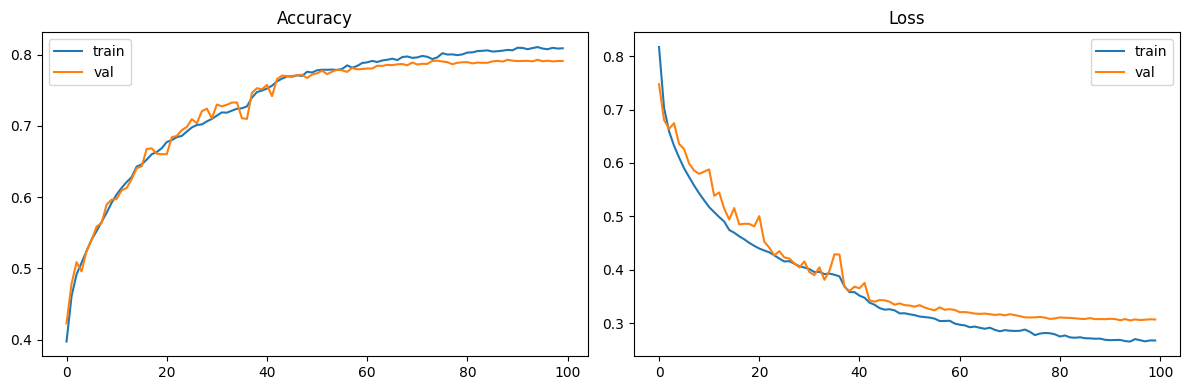

518/518 [==============================] - 10s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.55      0.65      3315
           1       0.92      0.95      0.94      3314
           2       0.61      0.70      0.65      3315
           3       0.96      0.90      0.93      3315
           4       0.71      0.85      0.77      3315

    accuracy                           0.79     16574
   macro avg       0.80      0.79      0.79     16574
weighted avg       0.80      0.79      0.79     16574

[[1831    4 1020    3  457]
 [  12 3141   31  106   24]
 [ 333    8 2334   11  629]
 [   7  241   37 2993   37]
 [  99    6  392    5 2813]]

🧠 Cohen Kappa Score: 0.7389


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxbck1k_r\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxbck1k_r\assets



⏱️ Total training time: 288.43 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt  # Added for DWT

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256  # Original sampling frequency
TARGET_FS = 34.3  # Target sampling frequency (from paper)
EPOCH_SAMPLES = 1024  # Samples per epoch at TARGET_FS
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)  # epochs in 1 hour
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR  # fixed length for each subject
DWT_LEVELS = 4  # Number of DWT decomposition levels
WAVELET = 'db4'  # Wavelet type for DWT

# --- Preprocessing functions ---

def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0  # avoid div by zero if flat signal
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Flatten and compute statistical features (mean, std, energy) for each coefficient
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c), np.std(c), np.sum(c**2)  # Mean, std, energy
        ])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    # 1. Filter
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    # 2. Detrend
    detrended = poly_detrend(filtered)
    # 3. Min-max normalization
    normalized = min_max_norm(detrended)
    # 4. Resample to target_fs
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    # 5. Epoching: slice into fixed length segments of epoch_samples
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    # 6. Reshape to epochs
    epochs = resampled.reshape(total_epochs, epoch_samples)
    # Create mask to mark zero-padded epochs
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    # 7. Extract DWT features for each epoch
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess once ---

folder_path = r"D:\abhishek_extracted\normal"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()

    # Preprocess raw signal to epochs + DWT features + mask
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)

    # Adjust sleep labels to epochs length
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)

    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)  # shape: (total_epochs * subjects, epoch_samples)
X_dwt_all = np.vstack(X_dwt_list)  # shape: (total_epochs * subjects, dwt_feature_size)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs for training ---
valid_idx = y_all != -1  # remove epochs with padded labels
valid_idx = valid_idx & (mask_all == 1)  # remove zero-padded epochs

X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Data Augmentation ---

def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Class-wise augmentation for minority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
minority_classes = np.where(np.bincount(y_all) < np.median(np.bincount(y_all)))[0]

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    if label in minority_classes:
        if np.random.rand() < 0.5:
            ppg = jitter(ppg)
            dwt = jitter(dwt, sigma=0.005)  # Smaller jitter for DWT features
        if np.random.rand() < 0.5:
            ppg = magnitude_warp(ppg)
            # DWT features are statistical, so avoid warping
        if np.random.rand() < 0.5:
            ppg = scaling(ppg)
            dwt = scaling(dwt, sigma=0.05)  # Smaller scaling for DWT
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)

scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
# Concatenate PPG and DWT features for SMOTE
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_all)

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha = [0.86, 1.19, 0.88, 1.00, 1.06]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    
    # PPG Input Branch (CNN)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)

    # First CNN Block
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)

    # MSR-SE Block
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)

    # Second Conv Block + Residual
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Frequency Fusion Block
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)

    # Third Conv Block
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)

    # Attention
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])

    # Residual Merge
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)

    # DWT Input Branch (MLP)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d

    # Combine PPG and DWT branches
    combined = Concatenate()([ppg_out, dwt_out])

    # RVFL Dense Layers
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),  # Slightly increased learning rate
              loss=focal_loss(gamma=1.5, alpha = [0.86, 1.19, 0.88, 1.00, 1.06]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat, 
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")



✅ Overall Test Accuracy: 0.7911


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7897148150945168
Weighted F1 Score: 0.7897060096147674
Macro Precision: 0.8016819121357062
Macro Recall: 0.7911280722307028


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")



📈 Final Accuracy: Train = 0.8090, Val = 0.7911
📉 Final Loss: Train = 0.2675, Val = 0.3068


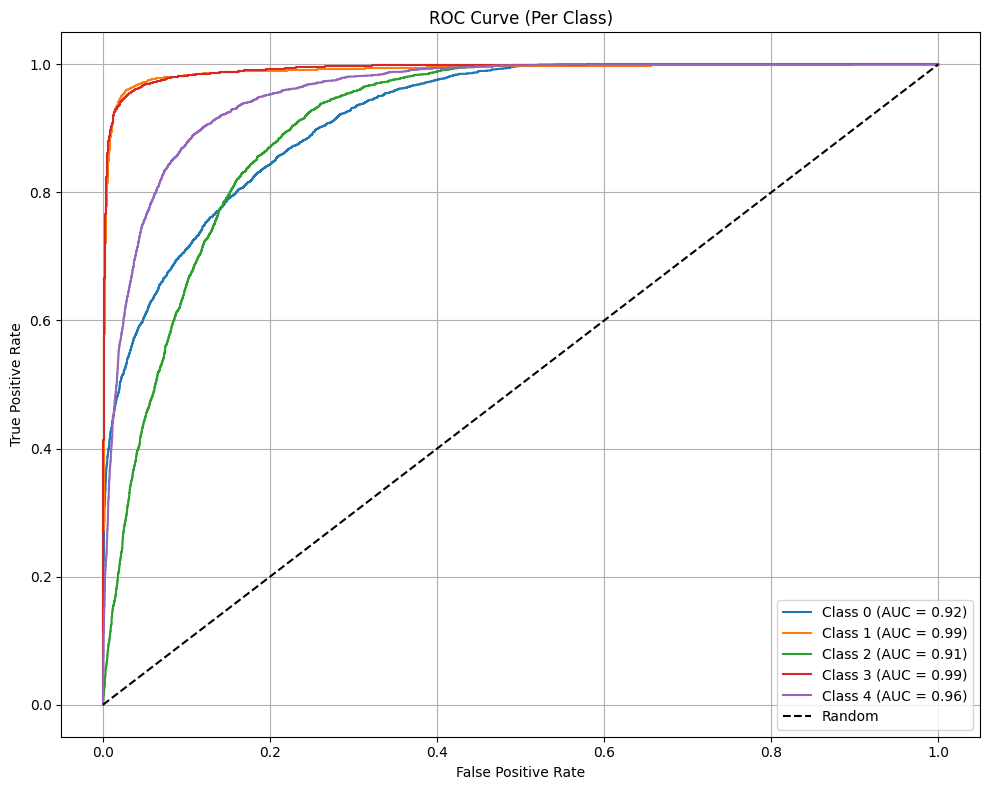

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


MSRFuseNet - Preprocessing - DWT(5 Features) - NORMAL - 39 - (SKEWNESS AND KURTOSIS) 

In [ ]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis  # Added for skewness and kurtosis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    nyq = 0.5 * fs
    wp = cutoff / nyq
    b, a = cheby2(order, rs, wp, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def poly_detrend(signal, degree=10):
    x = np.arange(len(signal))
    coefs = Polynomial.fit(x, signal, degree).convert().coef
    trend = np.polyval(coefs[::-1], x)
    detrended = signal - trend
    return detrended

def min_max_norm(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val - min_val == 0:
        return signal * 0
    return (signal - min_val) / (max_val - min_val)

def extract_dwt_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for c in coeffs:
        features.extend([
            np.mean(c),              # Mean
            np.std(c),               # Standard deviation
            np.sum(c**2),            # Energy
            skew(c, bias=False),     # Skewness
            kurtosis(c, bias=False)  # Kurtosis
        ])
    return np.array(features)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
    detrended = poly_detrend(filtered)
    normalized = min_max_norm(detrended)
    up = int(target_fs * 1000)
    down = int(orig_fs * 1000)
    gcd = np.gcd(up, down)
    up //= gcd
    down //= gcd
    resampled = resample_poly(normalized, up, down)
    total_samples = epoch_samples * total_epochs
    if len(resampled) > total_samples:
        resampled = resampled[:total_samples]
    elif len(resampled) < total_samples:
        pad_len = total_samples - len(resampled)
        resampled = np.pad(resampled, (0, pad_len), 'constant')
    epochs = resampled.reshape(total_epochs, epoch_samples)
    mask = np.array([0 if np.sum(e) == 0 else 1 for e in epochs])
    dwt_features = np.array([extract_dwt_features(epoch) for epoch in epochs])
    return epochs, dwt_features, mask

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\plm"
mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]

X_epochs_list = []
X_dwt_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    mat = scipy.io.loadmat(file)
    raw_signal = mat['ppg_signals'].flatten()
    sleep_labels = mat['sleep_stages'].flatten()
    epochs, dwt_features, mask = preprocess_ppg_signal(raw_signal)
    if len(sleep_labels) > epochs.shape[0]:
        sleep_labels = sleep_labels[:epochs.shape[0]]
    elif len(sleep_labels) < epochs.shape[0]:
        pad_len = epochs.shape[0] - len(sleep_labels)
        sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
    X_epochs_list.append(epochs)
    X_dwt_list.append(dwt_features)
    y_epochs_list.append(sleep_labels)
    mask_list.append(mask)

X_all = np.vstack(X_epochs_list)
X_dwt_all = np.vstack(X_dwt_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, DWT features per epoch: {X_dwt_all.shape[1]}")

# Save preprocessed data
np.save("ppg_epochs.npy", X_all)
np.save("dwt_features.npy", X_dwt_all)
np.save("sleep_labels.npy", y_all)
np.save("epoch_mask.npy", mask_all)

# --- Filter out zero-padded epochs ---
valid_idx = y_all != -1
valid_idx = valid_idx & (mask_all == 1)
X_all = X_all[valid_idx]
X_dwt_all = X_dwt_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

# Augment all classes, lighter for majority classes
np.random.seed(42)
augmented_ppg = []
augmented_dwt = []
augmented_labels = []
majority_classes = [0, 2]  # Stage 0 and Stage 2

for ppg, dwt, label in zip(X_all, X_dwt_all, y_all):
    augmented_ppg.append(ppg)
    augmented_dwt.append(dwt)
    augmented_labels.append(label)
    if label in majority_classes:
        # Lighter augmentation for Classes 0 and 2
        if np.random.rand() < 0.3:  # Lower probability
            aug_ppg = jitter(ppg, sigma=0.005)  # Smaller sigma
            aug_dwt = jitter(dwt, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_dwt = scaling(dwt, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
    else:
        # Stronger augmentation for Classes 1, 3, 4
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_dwt = jitter(dwt, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            aug_dwt = dwt  # No warping for DWT
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_dwt = scaling(dwt, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_dwt.append(aug_dwt)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_dwt_aug = np.array(augmented_dwt)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
scaler_ppg = StandardScaler()
X_scaled = scaler_ppg.fit_transform(X_aug)
scaler_dwt = StandardScaler()
X_dwt_scaled = scaler_dwt.fit_transform(X_dwt_aug)

# --- Handle Class Imbalance with SMOTE ---
X_combined = np.concatenate([X_scaled, X_dwt_scaled], axis=1)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_combined, y_aug)

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# Split back into PPG and DWT
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_dwt = X_res[:, X_scaled.shape[1]:]

# --- Class weights ---
class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Train-test split ---
X_train_ppg, X_test_ppg, X_train_dwt, X_test_dwt, y_train, y_test = train_test_split(
    X_res_ppg, X_res_dwt, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# Expand dims for CNN input
X_train_ppg = X_train_ppg[..., np.newaxis]
X_test_ppg = X_test_ppg[..., np.newaxis]

# One-hot encoding
num_classes = 5
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha = [0.86, 1.19, 0.88, 1.00, 1.06]):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, dwt_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation="relu", kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation="sigmoid", kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    dwt_input = Input(shape=dwt_shape, name='dwt_input')
    d = GaussianNoise(0.02)(dwt_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    dwt_out = d
    combined = Concatenate()([ppg_out, dwt_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=[ppg_input, dwt_input], outputs=outputs)

# --- Compile & train ---
model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_dwt.shape[1],))
model.compile(optimizer=Adam(2e-4),
              loss=focal_loss(gamma=1.5, alpha = [0.86, 1.19, 0.88, 1.00, 1.06]),
              metrics=['accuracy'])

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_dwt.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

history = model.fit([X_train_ppg, X_train_dwt], y_train_cat,
                    validation_data=([X_test_ppg, X_test_dwt], y_test_cat),
                    epochs=100, batch_size=32, class_weight=class_weight_dict,
                    callbacks=callbacks, verbose=1)

end_time = time.time()

# --- Plot training curves ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation ---
y_pred = model.predict([X_test_ppg, X_test_dwt])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_cls, y_pred_cls))

cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:")
print(cm)

kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")

# --- Save model ---
model.save("cnn_dwt_rvfl_light_model.keras")

# --- Export TFLite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("cnn_dwt_rvfl_light_model.tflite", "wb") as f:
    f.write(tflite_model)

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 5

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 2]  # Wake, N2

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.358, 1.592, 0.361, 1.595, 1.093]  # Based on pre-augmentation class distribution

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_5class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls, target_names=class_names))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_5class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_5class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 3726 samples (8.12%)
Class 2: 16437 samples (35.82%)
Class 3: 3718 samples (8.10%)
Class 4: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26531 samples (31.24%)
Class 1: 9242 samples (10.88%)
Class 2: 26322 samples (31.00%)
Class 3: 9229 samples (10.87%)
Class 4: 13596 samples (16.01%)

Class Distribution After SMOTE:
Class 0: 26531 samples (20.00%)
Class 1: 26531 samples (20.00%)
Class 2: 26531 samples (20.00%)
Class 3: 26531 samples (20.00%)
Class 4: 26531 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (Inp

 opout1D)                                                                                         
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_nor

                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_nor

Epoch 31/100
3317/3317 [==============================] - 276s 83ms/step - loss: 0.5400 - accuracy: 0.5874 - val_loss: 0.5207 - val_accuracy: 0.5884 - lr: 2.0000e-04
Epoch 32/100
3317/3317 [==============================] - 272s 82ms/step - loss: 0.5395 - accuracy: 0.5889 - val_loss: 0.5243 - val_accuracy: 0.5917 - lr: 2.0000e-04
Epoch 33/100
3317/3317 [==============================] - 268s 81ms/step - loss: 0.5375 - accuracy: 0.5907 - val_loss: 0.5152 - val_accuracy: 0.5996 - lr: 2.0000e-04
Epoch 34/100
3317/3317 [==============================] - 279s 84ms/step - loss: 0.5319 - accuracy: 0.5942 - val_loss: 0.5183 - val_accuracy: 0.5913 - lr: 2.0000e-04
Epoch 35/100
3317/3317 [==============================] - 269s 81ms/step - loss: 0.5285 - accuracy: 0.5947 - val_loss: 0.5068 - val_accuracy: 0.6038 - lr: 2.0000e-04
Epoch 36/100
3317/3317 [==============================] - 269s 81ms/step - loss: 0.5247 - accuracy: 0.5993 - val_loss: 0.5045 - val_accuracy: 0.6033 - lr: 2.0000e-04
Epoc

INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpqa82m_29\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpqa82m_29\assets



⏱️ Total training time: 455.86 minutes


In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.6918


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.6787516966778933
Weighted F1 Score: 0.6787568491559413
Macro Precision: 0.7038327066510982
Macro Recall: 0.6918239399761539


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7182, Val = 0.6918
📉 Final Loss: Train = 0.3433, Val = 0.3863


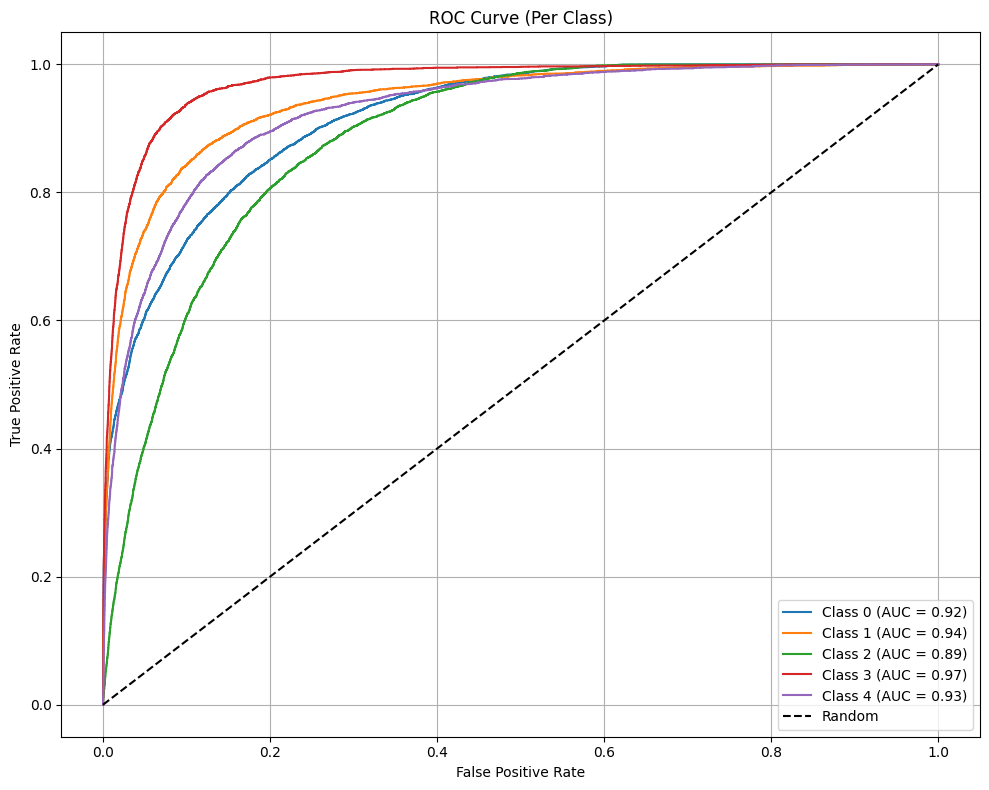

In [5]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
alpha = [0.6, 1.3, 0.7, 1.3, 1.0]

In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
import pywt
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_FS = 256
TARGET_FS = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_FS / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 5

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_FS, target_fs=TARGET_FS,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 2]  # Wake, N2

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.6, 1.3, 0.7, 1.3, 1.0]  # Based on pre-augmentation class distribution

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_5class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls, target_names=class_names))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_5class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_5class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 3726 samples (8.12%)
Class 2: 16437 samples (35.82%)
Class 3: 3718 samples (8.10%)
Class 4: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26531 samples (31.24%)
Class 1: 9242 samples (10.88%)
Class 2: 26322 samples (31.00%)
Class 3: 9229 samples (10.87%)
Class 4: 13596 samples (16.01%)

Class Distribution After SMOTE:
Class 0: 26531 samples (20.00%)
Class 1: 26531 samples (20.00%)
Class 2: 26531 samples (20.00%)
Class 3: 26531 samples (20.00%)
Class 4: 26531 samples (20.00%)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (Inp

 opout1D)                                                                                         
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_nor

                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_nor

Epoch 31/100
3317/3317 [==============================] - 262s 79ms/step - loss: 0.5698 - accuracy: 0.6272 - val_loss: 0.5566 - val_accuracy: 0.6326 - lr: 2.0000e-04
Epoch 32/100
3317/3317 [==============================] - 262s 79ms/step - loss: 0.5691 - accuracy: 0.6279 - val_loss: 0.5611 - val_accuracy: 0.6324 - lr: 2.0000e-04
Epoch 33/100
3317/3317 [==============================] - 262s 79ms/step - loss: 0.5630 - accuracy: 0.6329 - val_loss: 0.5490 - val_accuracy: 0.6443 - lr: 2.0000e-04
Epoch 34/100
3317/3317 [==============================] - 266s 80ms/step - loss: 0.5599 - accuracy: 0.6384 - val_loss: 0.5449 - val_accuracy: 0.6423 - lr: 2.0000e-04
Epoch 35/100
3317/3317 [==============================] - 265s 80ms/step - loss: 0.5589 - accuracy: 0.6386 - val_loss: 0.5508 - val_accuracy: 0.6382 - lr: 2.0000e-04
Epoch 36/100
3317/3317 [==============================] - 265s 80ms/step - loss: 0.5520 - accuracy: 0.6407 - val_loss: 0.5452 - val_accuracy: 0.6464 - lr: 2.0000e-04
Epoc

INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp2k1u6e3k\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp2k1u6e3k\assets



⏱️ Total training time: 430.85 minutes


In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7188


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7129645092040128
Weighted F1 Score: 0.7129686506100924
Macro Precision: 0.7228514162884252
Macro Recall: 0.7187754781411886


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7501, Val = 0.7188
📉 Final Loss: Train = 0.3695, Val = 0.4337


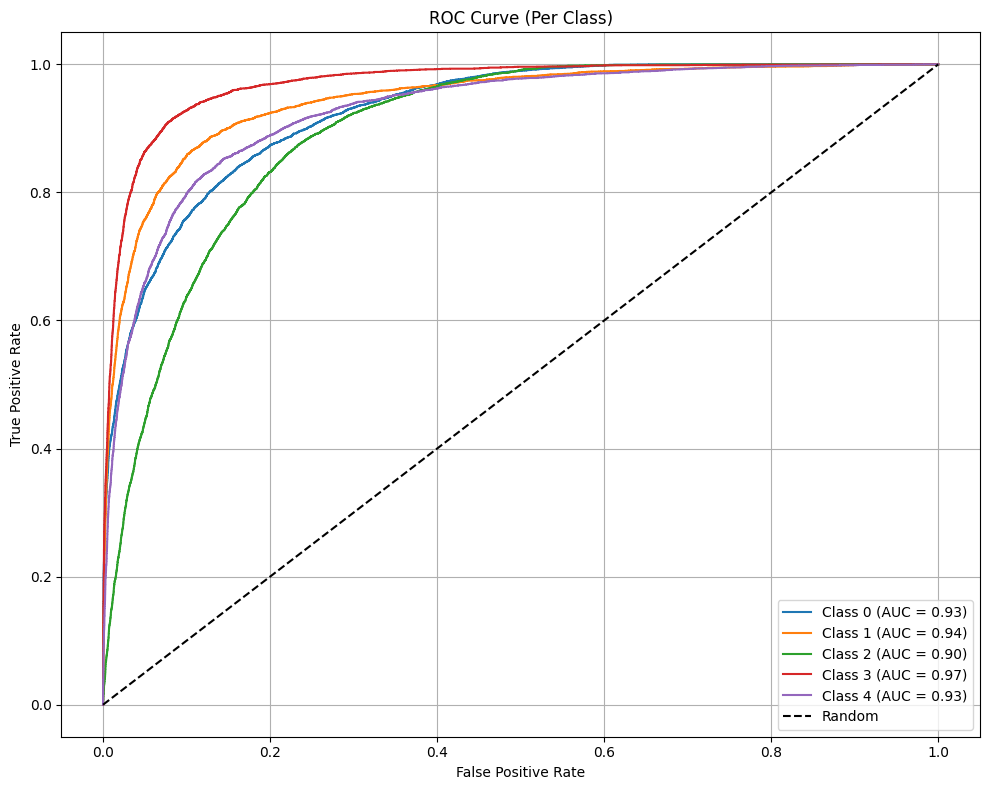

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
[0.6, 0.6, 1.4, 1.0]

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 20163 samples (43.94%)
Class 2: 3718 samples (8.10%)
Class 3: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26422 samples (32.43%)
Class 1: 32202 samples (39.53%)
Class 2: 9352 samples (11.48%)
Class 3: 13488 samples (16.56%)

Class Distribution After SMOTE:
Class 0: 32202 samples (25.00%)
Class 1: 32202 samples (25.00%)
Class 2: 32202 samples (25.00%)
Class 3: 32202 samples (25.00%)

Fixed Focal Loss Alpha: [0.6, 0.6, 1.4, 1.0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0        

                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalizati

 dropout (Dropout)              (None, 64)           0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalizat

3221/3221 [==============================] - 250s 78ms/step - loss: 0.2501 - accuracy: 0.7731 - val_loss: 0.2790 - val_accuracy: 0.7562 - lr: 6.2500e-06
Epoch 81/100
3221/3221 [==============================] - 253s 79ms/step - loss: 0.2508 - accuracy: 0.7747 - val_loss: 0.2769 - val_accuracy: 0.7556 - lr: 6.2500e-06
Epoch 82/100
3221/3221 [==============================] - 258s 80ms/step - loss: 0.2511 - accuracy: 0.7718 - val_loss: 0.2779 - val_accuracy: 0.7546 - lr: 6.2500e-06
Epoch 83/100
3221/3221 [==============================] - 257s 80ms/step - loss: 0.2494 - accuracy: 0.7739 - val_loss: 0.2785 - val_accuracy: 0.7556 - lr: 6.2500e-06
Epoch 84/100
3221/3221 [==============================] - 261s 81ms/step - loss: 0.2495 - accuracy: 0.7730 - val_loss: 0.2774 - val_accuracy: 0.7549 - lr: 6.2500e-06
Epoch 85/100
3221/3221 [==============================] - 264s 82ms/step - loss: 0.2486 - accuracy: 0.7736 - val_loss: 0.2770 - val_accuracy: 0.7549 - lr: 3.1250e-06
Epoch 86/100
3221

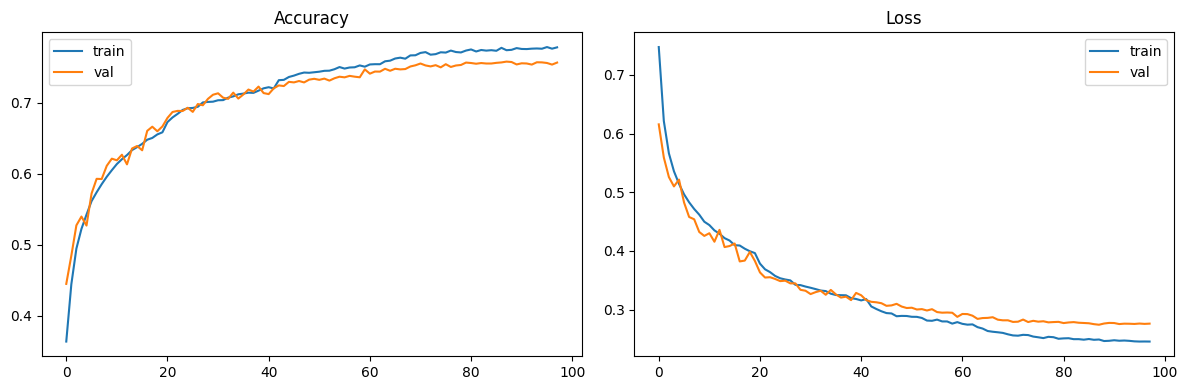

806/806 [==============================] - 14s 16ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      6441
           1       0.70      0.61      0.65      6440
           2       0.82      0.92      0.87      6441
           3       0.71      0.85      0.78      6440

    accuracy                           0.76     25762
   macro avg       0.76      0.76      0.75     25762
weighted avg       0.76      0.76      0.75     25762

Confusion Matrix:
[[4220 1219  217  785]
 [ 889 3911  563 1077]
 [  23  185 5900  333]
 [ 139  304  511 5486]]

🧠 Cohen Kappa Score: 0.6768


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp48ydlvym\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp48ydlvym\assets



⏱️ Total training time: 423.36 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 4

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_4_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> Light Sleep
        2: 1,  # N2 -> Light Sleep
        3: 2,  # N3 -> Deep Sleep
        4: 3   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_4_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_4class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, Light Sleep

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed alpha for focal loss ---
alpha_fixed = np.array([0.6, 0.6, 1.4, 1.0])
print(f"\nFixed Focal Loss Alpha: {alpha_fixed.tolist()}")

# --- Focal loss function ---
def focal_loss(gamma=1.5, alpha=alpha_fixed):
    alpha = tf.constant(alpha, dtype=tf.float32)
    
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5, alpha=alpha_fixed),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_4class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_4class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_4class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7576


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7529704265603083
Weighted F1 Score: 0.7529735434724586
Macro Precision: 0.7578345919227523
Macro Recall: 0.7575865223370084


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7776, Val = 0.7562
📉 Final Loss: Train = 0.2454, Val = 0.2759


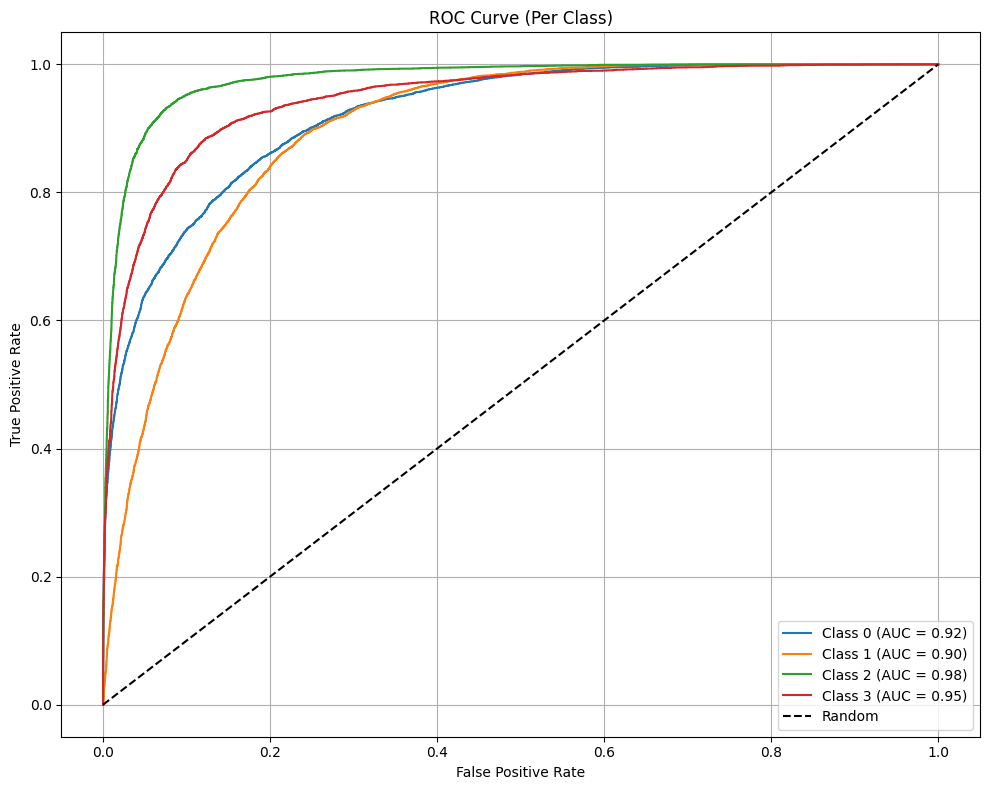

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 4
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 23881 samples (52.05%)
Class 2: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26547 samples (33.89%)
Class 1: 38210 samples (48.78%)
Class 2: 13572 samples (17.33%)

Class Distribution After SMOTE:
Class 0: 38210 samples (33.33%)
Class 1: 38210 samples (33.33%)
Class 2: 38210 samples (33.33%)

Fixed Focal Loss Alpha: [0.535, 0.465, 2.0]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                         

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2866/2866 [==============================] - 230s 80ms/step - loss: 0.2098 - accuracy: 0.7367 - val_loss: 0.2529 - val_accuracy: 0.7335 - lr: 2.5000e-05
Epoch 33/100
2866/2866 [==============================] - 232s 81ms/step - loss: 0.2098 - accuracy: 0.7383 - val_loss: 0.2485 - val_accuracy: 0.7321 - lr: 1.2500e-05
Epoch 34/100
2866/2866 [==============================] - 232s 81ms/step - loss: 0.2068 - accuracy: 0.7409 - val_loss: 0.2494 - val_accuracy: 0.7303 - lr: 1.2500e-05
Epoch 35/100
2866/2866 [==============================] - 231s 81ms/step - loss: 0.2072 - accuracy: 0.7426 - val_loss: 0.2504 - val_accuracy: 0.7303 - lr: 1.2500e-05
Epoch 36/100
2866/2866 [==============================] - 231s 81ms/step - loss: 0.2078 - accuracy: 0.7427 - val_loss: 0.2483 - val_accuracy: 0.7323 - lr: 1.2500e-05
Epoch 37/100
2866/2866 [==============================] - 231s 81ms/step - loss: 0.2067 - accuracy: 0.7401 - val_loss: 0.2464 - val_accuracy: 0.7399 - lr: 1.2500e-05
Epoch 38/100
2866

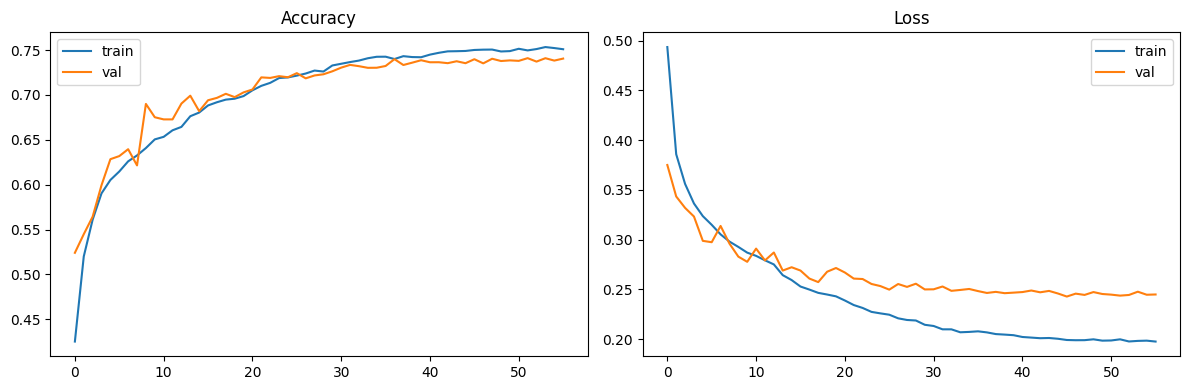

717/717 [==============================] - 15s 20ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.62      0.70      7642
           1       0.72      0.68      0.70      7642
           2       0.71      0.92      0.80      7642

    accuracy                           0.74     22926
   macro avg       0.75      0.74      0.73     22926
weighted avg       0.75      0.74      0.73     22926

Confusion Matrix:
[[4703 1588 1351]
 [ 940 5205 1497]
 [ 112  476 7054]]

🧠 Cohen Kappa Score: 0.6098


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxlew3pw3\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpxlew3pw3\assets



⏱️ Total training time: 214.97 minutes


In [6]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.535, 0.465, 2.000]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [7]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7399


In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7347964541201534
Weighted F1 Score: 0.7347964541201535
Macro Precision: 0.7485460825635984
Macro Recall: 0.7398586757393354


In [9]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7510, Val = 0.7406
📉 Final Loss: Train = 0.1975, Val = 0.2449


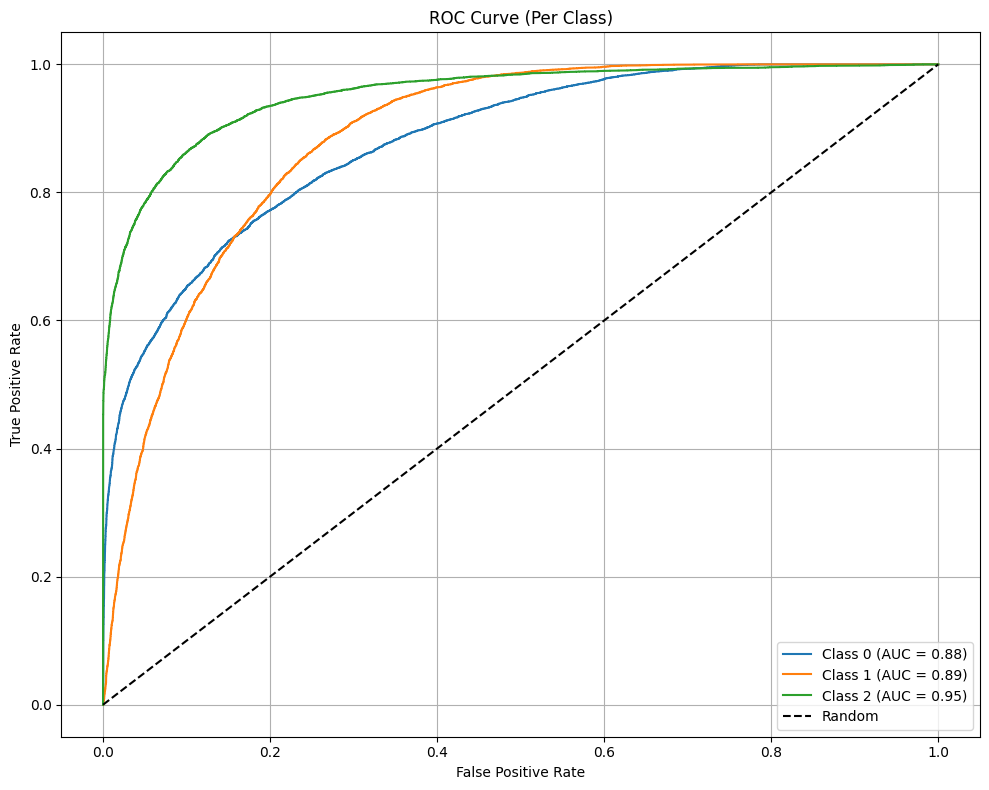

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 23881 samples (52.05%)
Class 2: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26547 samples (33.89%)
Class 1: 38210 samples (48.78%)
Class 2: 13572 samples (17.33%)

Class Distribution After SMOTE:
Class 0: 38210 samples (33.33%)
Class 1: 38210 samples (33.33%)
Class 2: 38210 samples (33.33%)

Fixed Focal Loss Alpha: [0.179, 0.155, 0.666]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                       

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2866/2866 [==============================] - 225s 79ms/step - loss: 0.0732 - accuracy: 0.7290 - val_loss: 0.0884 - val_accuracy: 0.7228 - lr: 2.5000e-05
Epoch 33/100
2866/2866 [==============================] - 225s 78ms/step - loss: 0.0725 - accuracy: 0.7310 - val_loss: 0.0869 - val_accuracy: 0.7294 - lr: 2.5000e-05
Epoch 34/100
2866/2866 [==============================] - 226s 79ms/step - loss: 0.0723 - accuracy: 0.7305 - val_loss: 0.0864 - val_accuracy: 0.7209 - lr: 2.5000e-05
Epoch 35/100
2866/2866 [==============================] - 224s 78ms/step - loss: 0.0717 - accuracy: 0.7316 - val_loss: 0.0872 - val_accuracy: 0.7258 - lr: 2.5000e-05
Epoch 36/100
2866/2866 [==============================] - 226s 79ms/step - loss: 0.0714 - accuracy: 0.7343 - val_loss: 0.0869 - val_accuracy: 0.7287 - lr: 2.5000e-05
Epoch 37/100
2866/2866 [==============================] - 227s 79ms/step - loss: 0.0710 - accuracy: 0.7349 - val_loss: 0.0870 - val_accuracy: 0.7281 - lr: 2.5000e-05
Epoch 38/100
2866

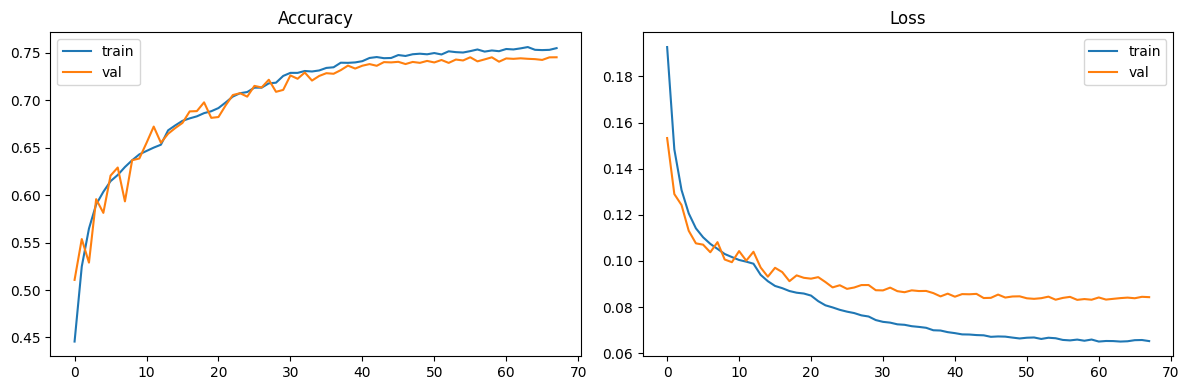

717/717 [==============================] - 16s 21ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      7642
           1       0.71      0.68      0.69      7642
           2       0.72      0.92      0.81      7642

    accuracy                           0.74     22926
   macro avg       0.75      0.74      0.74     22926
weighted avg       0.75      0.74      0.74     22926

Confusion Matrix:
[[4837 1632 1173]
 [ 971 5175 1496]
 [ 125  489 7028]]

🧠 Cohen Kappa Score: 0.6149


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpzi36dqsg\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmpzi36dqsg\assets



⏱️ Total training time: 256.39 minutes


In [11]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.179, 0.155, 0.666]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [12]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.7433


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.7387184695956096
Weighted F1 Score: 0.7387184695956097
Macro Precision: 0.7497745063659788
Macro Recall: 0.7432609264590422


In [14]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.7551, Val = 0.7455
📉 Final Loss: Train = 0.0652, Val = 0.0843


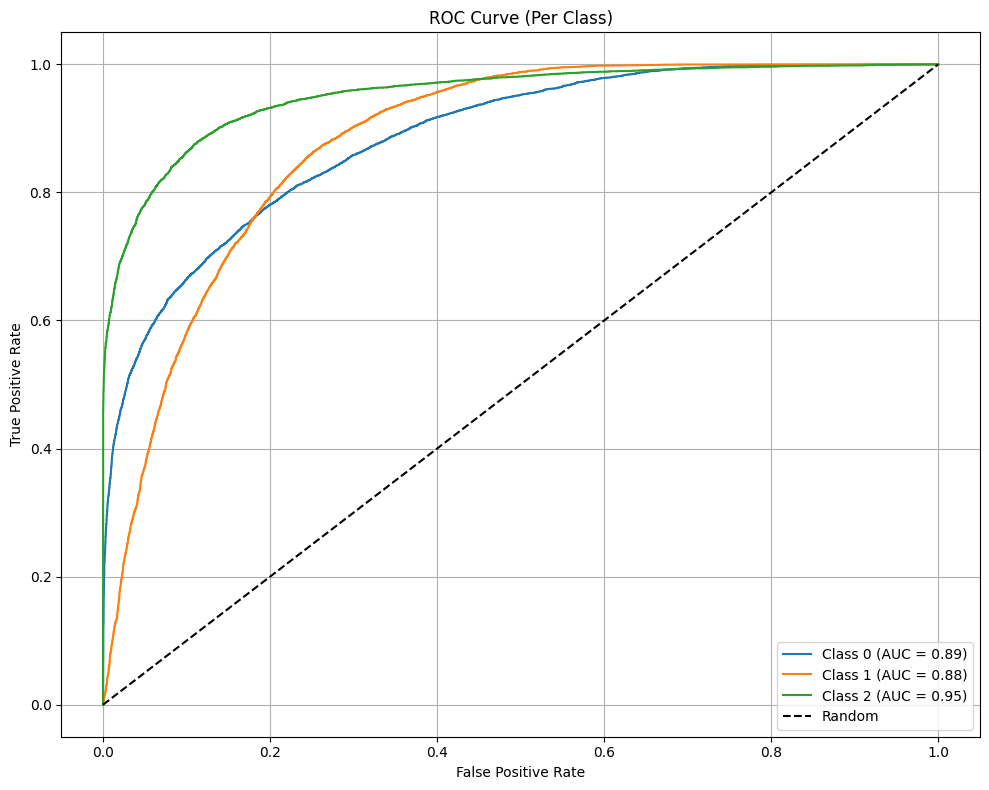

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



2 class 

✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 29311 samples (63.88%)

Class Distribution After Augmentation:
Class 0: 26571 samples (36.14%)
Class 1: 46946 samples (63.86%)

Class Distribution After SMOTE:
Class 0: 46946 samples (50.00%)
Class 1: 46946 samples (50.00%)

Fixed Focal Loss Alpha: [0.5866, 0.4134]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 1024, 1)     0  

                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 tf.math.s

 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 concatena

Epoch 33/100
2348/2348 [==============================] - 163s 70ms/step - loss: 0.0637 - accuracy: 0.8777 - val_loss: 0.0824 - val_accuracy: 0.8477 - lr: 2.5000e-05
Epoch 34/100
2348/2348 [==============================] - 164s 70ms/step - loss: 0.0632 - accuracy: 0.8775 - val_loss: 0.0823 - val_accuracy: 0.8446 - lr: 2.5000e-05
Epoch 35/100
2348/2348 [==============================] - 164s 70ms/step - loss: 0.0626 - accuracy: 0.8797 - val_loss: 0.0826 - val_accuracy: 0.8461 - lr: 2.5000e-05
Epoch 36/100
2348/2348 [==============================] - 165s 70ms/step - loss: 0.0615 - accuracy: 0.8820 - val_loss: 0.0825 - val_accuracy: 0.8503 - lr: 2.5000e-05
Epoch 37/100
2348/2348 [==============================] - 169s 72ms/step - loss: 0.0606 - accuracy: 0.8839 - val_loss: 0.0820 - val_accuracy: 0.8507 - lr: 1.2500e-05
Epoch 38/100
2348/2348 [==============================] - 163s 70ms/step - loss: 0.0598 - accuracy: 0.8869 - val_loss: 0.0824 - val_accuracy: 0.8497 - lr: 1.2500e-05
Epoc

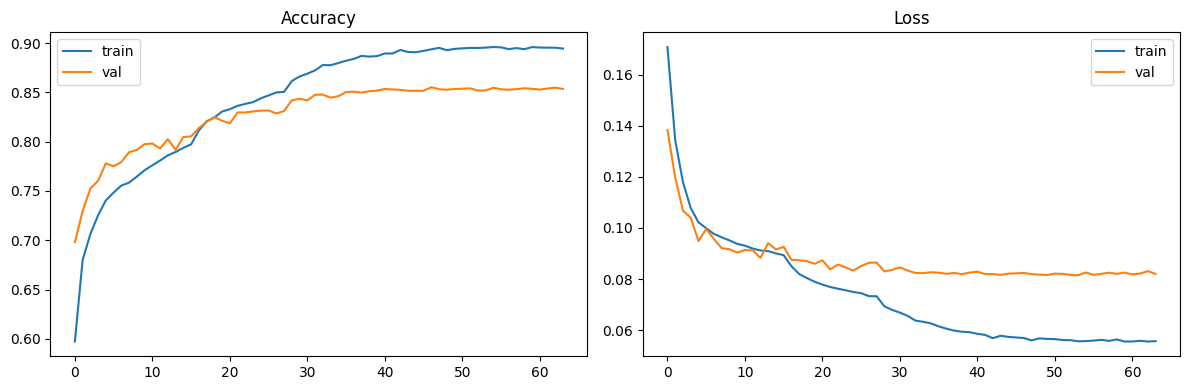

587/587 [==============================] - 12s 19ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      9390
           1       0.86      0.85      0.85      9389

    accuracy                           0.85     18779
   macro avg       0.85      0.85      0.85     18779
weighted avg       0.85      0.85      0.85     18779

Confusion Matrix:
[[8044 1346]
 [1436 7953]]

🧠 Cohen Kappa Score: 0.7037


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp5s5k7k_f\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp5s5k7k_f\assets



⏱️ Total training time: 212.87 minutes


In [1]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 2

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 1   # No-Wake
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# --- Class weights ---
try:
    class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
except Exception as e:
    print(f"Error computing class weights: {e}")
    exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.5866, 0.4134]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32, class_weight=class_weight_dict,
                        callbacks=callbacks, verbose=1)
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")

In [2]:
from sklearn.metrics import accuracy_score

total_acc = accuracy_score(y_true_cls, y_pred_cls)
print(f"\n✅ Overall Test Accuracy: {total_acc:.4f}")


✅ Overall Test Accuracy: 0.8519


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("Macro F1 Score:", f1_score(y_true_cls, y_pred_cls, average='macro'))
print("Weighted F1 Score:", f1_score(y_true_cls, y_pred_cls, average='weighted'))
print("Macro Precision:", precision_score(y_true_cls, y_pred_cls, average='macro'))
print("Macro Recall:", recall_score(y_true_cls, y_pred_cls, average='macro'))


Macro F1 Score: 0.8518523175421594
Weighted F1 Score: 0.8518523557710179
Macro Precision: 0.851888229894508
Macro Recall: 0.8518555407382554


In [4]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📈 Final Accuracy: Train = {final_train_acc:.4f}, Val = {final_val_acc:.4f}")
print(f"📉 Final Loss: Train = {final_train_loss:.4f}, Val = {final_val_loss:.4f}")


📈 Final Accuracy: Train = 0.8944, Val = 0.8535
📉 Final Loss: Train = 0.0557, Val = 0.0820


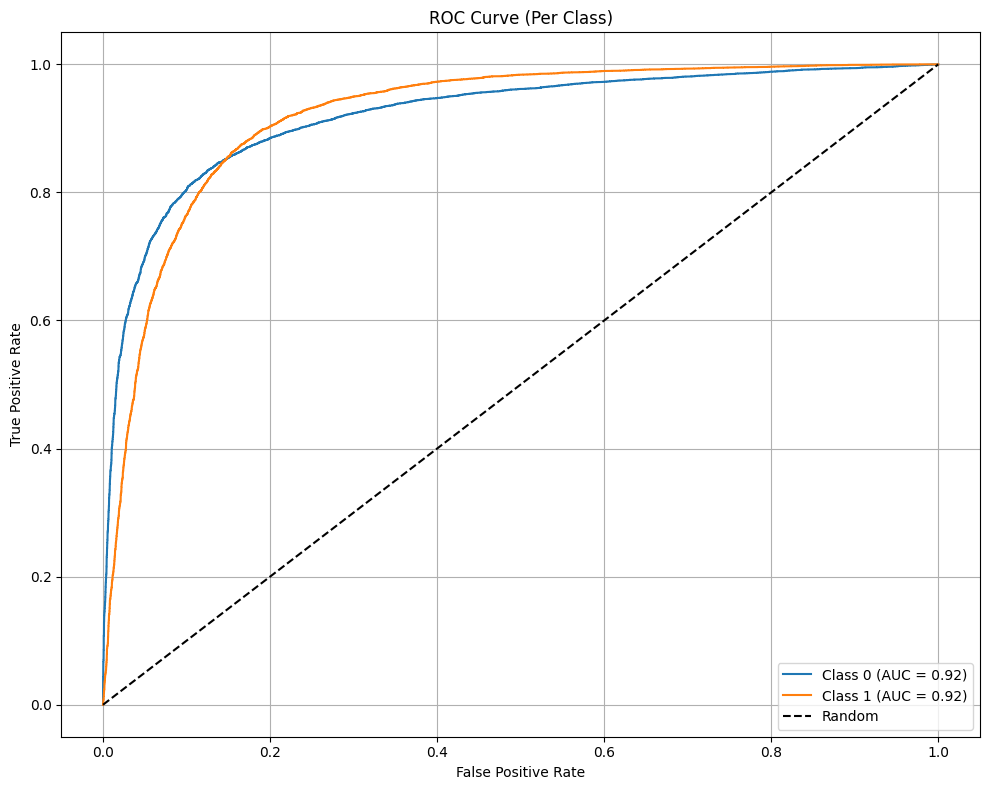

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure y_test is binarized
n_classes = 2
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



✅ GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total epochs: 46800, Each epoch samples: 1024, Features per epoch: 28
Valid epochs after masking: 45885

Class Distribution Before Augmentation:
Class 0: 16574 samples (36.12%)
Class 1: 23881 samples (52.05%)
Class 2: 5430 samples (11.83%)

Class Distribution After Augmentation:
Class 0: 26547 samples (33.89%)
Class 1: 38210 samples (48.78%)
Class 2: 13572 samples (17.33%)

Class Distribution After SMOTE:
Class 0: 38210 samples (33.33%)
Class 1: 38210 samples (33.33%)
Class 2: 38210 samples (33.33%)

Fixed Focal Loss Alpha: [0.179, 0.155, 0.666]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ppg_input (InputLayer)         [(None, 1024, 1)]    0           []                               
                                                       

 max_pooling1d_1 (MaxPooling1D)  (None, 256, 32)     0           ['spatial_dropout1d_1[0][0]']    
                                                                                                  
 separable_conv1d_8 (SeparableC  (None, 256, 32)     1280        ['max_pooling1d_1[0][0]']        
 onv1D)                                                                                           
                                                                                                  
 average_pooling1d (AveragePool  (None, 256, 32)     0           ['max_pooling1d_1[0][0]']        
 ing1D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 256, 32)     128         ['separable_conv1d_8[0][0]']     
 rmalization)                                                                                     
          

                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 64)     128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 32)           2080        ['dropout[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['layer_normalization_2[0][0]']  
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32)          128         ['dense_5[0][0]']                
 ormalization)                                                                                    
          

2866/2866 [==============================] - 248s 87ms/step - loss: 0.0722 - accuracy: 0.7450 - val_loss: 0.0818 - val_accuracy: 0.7138 - lr: 5.0000e-05
Epoch 33/100
2866/2866 [==============================] - 248s 86ms/step - loss: 0.0715 - accuracy: 0.7501 - val_loss: 0.0809 - val_accuracy: 0.7182 - lr: 5.0000e-05
Epoch 34/100
2866/2866 [==============================] - 247s 86ms/step - loss: 0.0713 - accuracy: 0.7510 - val_loss: 0.0819 - val_accuracy: 0.7089 - lr: 5.0000e-05
Epoch 35/100
2866/2866 [==============================] - 246s 86ms/step - loss: 0.0709 - accuracy: 0.7515 - val_loss: 0.0825 - val_accuracy: 0.7111 - lr: 5.0000e-05
Epoch 36/100
2866/2866 [==============================] - 250s 87ms/step - loss: 0.0707 - accuracy: 0.7539 - val_loss: 0.0828 - val_accuracy: 0.7100 - lr: 5.0000e-05
Epoch 37/100
2866/2866 [==============================] - 250s 87ms/step - loss: 0.0684 - accuracy: 0.7587 - val_loss: 0.0794 - val_accuracy: 0.7204 - lr: 2.5000e-05
Epoch 38/100
2866

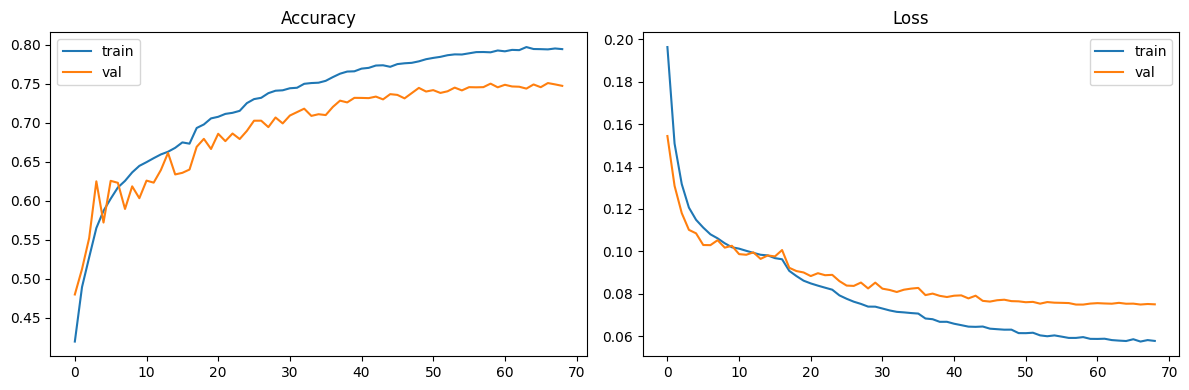

717/717 [==============================] - 12s 15ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      7642
           1       0.78      0.62      0.69      7642
           2       0.70      0.95      0.81      7642

    accuracy                           0.75     22926
   macro avg       0.76      0.75      0.74     22926
weighted avg       0.76      0.75      0.74     22926

Confusion Matrix:
[[5161 1150 1331]
 [1099 4750 1793]
 [ 131  221 7290]]

🧠 Cohen Kappa Score: 0.6254


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9abgvbcw\assets


INFO:tensorflow:Assets written to: C:\Users\DST\AppData\Local\Temp\tmp9abgvbcw\assets



⏱️ Total training time: 286.86 minutes


In [6]:
import numpy as np
import os, glob, scipy.io, time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import cheby2, filtfilt, resample_poly
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, SeparableConv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Flatten, Dense, Dropout, Multiply, Add, LayerNormalization,
                                     Lambda, GaussianNoise, BatchNormalization, SpatialDropout1D,
                                     Concatenate, Masking)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set global random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tf.keras.backend.clear_session()

# --- GPU setup ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0]}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("⚠️ No GPU found. Training might be slow.")

# --- Constants ---
ORIG_SF = 256
TARGET_SF = 34.3
EPOCH_SAMPLES = 1024
TOTAL_HOURS = 10
EPOCHS_PER_HOUR = int(3600 * TARGET_SF / EPOCH_SAMPLES)
TOTAL_EPOCHS = TOTAL_HOURS * EPOCHS_PER_HOUR
DWT_LEVELS = 4
WAVELET = 'db4'
NUM_CLASSES = 3

# --- Hjorth Parameters ---
def hjorth_parameters(signal):
    try:
        activity = np.var(signal)
        diff = np.diff(signal)
        mobility = np.std(diff) / (np.std(signal) + 1e-10)
        diff2 = np.diff(diff)
        complexity = (np.std(diff2) / (np.std(diff) + 1e-10)) / (mobility + 1e-10)
        return np.array([activity, mobility, complexity])
    except Exception as e:
        print(f"Error in Hjorth parameters: {e}")
        return np.zeros(3)

# --- Preprocessing functions ---
def cheby2_lowpass_filter(signal, fs, cutoff=8, order=8, rs=40):
    try:
        nyq = 0.5 * fs
        wp = cutoff / nyq
        b, a = cheby2(order, rs, wp, btype='low', analog=False)
        filtered = filtfilt(b, a, signal)
        return filtered
    except Exception as e:
        print(f"Error in cheby2 filter: {e}")
        return signal

def poly_detrend(signal, degree=10):
    try:
        x = np.arange(len(signal))
        coefs = Polynomial.fit(x, signal, degree).convert().coef
        trend = np.polyval(coefs[::-1], x)
        detrended = signal - trend
        return detrended
    except Exception as e:
        print(f"Error in detrending: {e}")
        return signal

def min_max_norm(signal):
    try:
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val - min_val == 0:
            return signal * 0
        return (signal - min_val) / (max_val - min_val)
    except Exception as e:
        print(f"Error in normalization: {e}")
        return signal

def extract_features(signal, wavelet=WAVELET, level=DWT_LEVELS):
    try:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dwt_features = []
        for c in coeffs:
            dwt_features.extend([
                np.mean(c),
                np.std(c),
                np.sum(c**2),
                skew(c, bias=False) if np.std(c) > 1e-10 else 0.0,
                kurtosis(c, bias=False) if np.std(c) > 1e-10 else 0.0
            ])
        hjorth = hjorth_parameters(signal)
        features = np.concatenate([dwt_features, hjorth])
        return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        return np.zeros(28)

def map_to_3_classes(y):
    mapping = {
        0: 0,  # Wake
        1: 1,  # N1 -> NREM
        2: 1,  # N2 -> NREM
        3: 1,  # N3 -> NREM
        4: 2   # REM
    }
    return np.vectorize(mapping.get)(y)

def preprocess_ppg_signal(ppg_signal, orig_fs=ORIG_SF, target_fs=TARGET_SF,
                          epoch_samples=EPOCH_SAMPLES, total_epochs=TOTAL_EPOCHS):
    try:
        filtered = cheby2_lowpass_filter(ppg_signal, orig_fs)
        detrended = poly_detrend(filtered)
        normalized = min_max_norm(detrended)
        up = int(target_fs * 1000)
        down = int(orig_fs * 1000)
        gcd = np.gcd(up, down)
        up //= gcd
        down //= gcd
        resampled = resample_poly(normalized, up, down)
        total_samples = epoch_samples * total_epochs
        if len(resampled) > total_samples:
            resampled = resampled[:total_samples]
        elif len(resampled) < total_samples:
            pad_len = total_samples - len(resampled)
            resampled = np.pad(resampled, (0, pad_len), 'constant')
        epochs = resampled.reshape(total_epochs, epoch_samples)
        mask = np.array([0 if np.sum(np.abs(e)) < 1e-10 else 1 for e in epochs])
        features = np.array([extract_features(epoch) for epoch in epochs])
        return epochs, features, mask
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return np.zeros((total_epochs, epoch_samples)), np.zeros((total_epochs, 28)), np.zeros(total_epochs)

# --- Load raw data and preprocess ---
folder_path = r"D:\abhishek_extracted\normal"
try:
    mat_files = sorted(glob.glob(os.path.join(folder_path, "*.mat")))[:39]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {folder_path}")
except Exception as e:
    print(f"Error loading files: {e}")
    exit(1)

X_epochs_list = []
X_features_list = []
y_epochs_list = []
mask_list = []

for file in mat_files:
    try:
        mat = scipy.io.loadmat(file)
        raw_signal = mat['ppg_signals'].flatten()
        sleep_labels = mat['sleep_stages'].flatten()
        sleep_labels = map_to_3_classes(sleep_labels)
        epochs, features, mask = preprocess_ppg_signal(raw_signal)
        if len(sleep_labels) > epochs.shape[0]:
            sleep_labels = sleep_labels[:epochs.shape[0]]
        elif len(sleep_labels) < epochs.shape[0]:
            pad_len = epochs.shape[0] - len(sleep_labels)
            sleep_labels = np.pad(sleep_labels, (0, pad_len), constant_values=-1)
        X_epochs_list.append(epochs)
        X_features_list.append(features)
        y_epochs_list.append(sleep_labels)
        mask_list.append(mask)
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

if not X_epochs_list:
    print("No valid data loaded. Exiting.")
    exit(1)

X_all = np.vstack(X_epochs_list)
X_features_all = np.vstack(X_features_list)
y_all = np.concatenate(y_epochs_list)
mask_all = np.concatenate(mask_list)

print(f"Total epochs: {X_all.shape[0]}, Each epoch samples: {X_all.shape[1]}, Features per epoch: {X_features_all.shape[1]}")

# Save preprocessed data
try:
    np.save("ppg_epochs.npy", X_all)
    np.save("features.npy", X_features_all)
    np.save("sleep_labels_3class.npy", y_all)
    np.save("epoch_mask.npy", mask_all)
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

# --- Filter out invalid epochs ---
valid_idx = (y_all != -1) & (mask_all == 1)
X_all = X_all[valid_idx]
X_features_all = X_features_all[valid_idx]
y_all = y_all[valid_idx]

print(f"Valid epochs after masking: {len(y_all)}")
if len(y_all) == 0:
    print("No valid epochs after masking. Exiting.")
    exit(1)

# --- Print class distribution before augmentation ---
print("\nClass Distribution Before Augmentation:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_all)*100:.2f}%)")

# --- Data Augmentation ---
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0, scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    return x * np.random.normal(loc=1.0, scale=sigma, size=x.shape)

def magnitude_warp(x, sigma=0.2):
    x = x.reshape(-1)
    warp = np.sin(np.linspace(0, np.pi, len(x))) * np.random.normal(1, sigma)
    return x * warp

np.random.seed(42)
augmented_ppg = []
augmented_features = []
augmented_labels = []
majority_classes = [0, 1]  # Wake, NREM

for ppg, feat, label in zip(X_all, X_features_all, y_all):
    augmented_ppg.append(ppg)
    augmented_features.append(feat)
    augmented_labels.append(label)
    if label in majority_classes:
        if np.random.rand() < 0.3:
            aug_ppg = jitter(ppg, sigma=0.005)
            aug_feat = jitter(feat, sigma=0.002)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.3:
            aug_ppg = scaling(ppg, sigma=0.05)
            aug_feat = scaling(feat, sigma=0.02)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
    else:
        if np.random.rand() < 0.5:
            aug_ppg = jitter(ppg)
            aug_feat = jitter(feat, sigma=0.005)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = magnitude_warp(ppg)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(feat)
            augmented_labels.append(label)
        if np.random.rand() < 0.5:
            aug_ppg = scaling(ppg)
            aug_feat = scaling(feat, sigma=0.05)
            augmented_ppg.append(aug_ppg)
            augmented_features.append(aug_feat)
            augmented_labels.append(label)

X_aug = np.array(augmented_ppg)
X_features_aug = np.array(augmented_features)
y_aug = np.array(augmented_labels)

# --- Print class distribution after augmentation ---
print("\nClass Distribution After Augmentation:")
unique, counts = np.unique(y_aug, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_aug)*100:.2f}%)")

# --- Standardization ---
try:
    scaler_ppg = StandardScaler()
    X_scaled = scaler_ppg.fit_transform(X_aug)
    scaler_features = StandardScaler()
    X_features_scaled = scaler_features.fit_transform(X_features_aug)
except Exception as e:
    print(f"Error in standardization: {e}")
    exit(1)

# --- Validate data ---
if np.any(np.isnan(X_scaled)) or np.any(np.isinf(X_scaled)):
    raise ValueError("NaN or infinite values in X_scaled")
if np.any(np.isnan(X_features_scaled)) or np.any(np.isinf(X_features_scaled)):
    raise ValueError("NaN or infinite values in X_features_scaled")
if X_scaled.shape[0] != y_aug.shape[0] or X_features_scaled.shape[0] != y_aug.shape[0]:
    raise ValueError(f"Inconsistent sample sizes: X_scaled={X_scaled.shape[0]}, X_features_scaled={X_features_scaled.shape[0]}, y_aug={y_aug.shape[0]}")

# --- Handle Class Imbalance with SMOTE ---
try:
    X_combined = np.concatenate([X_scaled, X_features_scaled], axis=1)
    min_samples = 6  # SMOTE k_neighbors=5 requires at least 6 samples
    class_counts = np.bincount(y_aug.astype(int), minlength=NUM_CLASSES)
    if np.any(class_counts < min_samples):
        print("\nWarning: Some classes have too few samples for SMOTE. Adjusting k_neighbors.")
        k_neighbors = min(np.min(class_counts[class_counts > 0]) - 1, 5)
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors if k_neighbors > 0 else 1)
    else:
        smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_combined, y_aug)
except Exception as e:
    print(f"Error in SMOTE: {e}")
    exit(1)

# Split back into PPG and features
X_res_ppg = X_res[:, :X_scaled.shape[1]]
X_res_features = X_res[:, X_scaled.shape[1]:]

# --- Print class distribution after SMOTE ---
print("\nClass Distribution After SMOTE:")
unique, counts = np.unique(y_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count} samples ({count/len(y_res)*100:.2f}%)")

# # --- Class weights ---
# try:
#     class_weights = compute_class_weight("balanced", classes=np.unique(y_res), y=y_res)
#     class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# except Exception as e:
#     print(f"Error computing class weights: {e}")
#     exit(1)

# --- Train-test split ---
try:
    X_train_ppg, X_test_ppg, X_train_features, X_test_features, y_train, y_test = train_test_split(
        X_res_ppg, X_res_features, y_res, test_size=0.2, stratify=y_res, random_state=42
    )
except Exception as e:
    print(f"Error in train-test split: {e}")
    exit(1)

# Expand dims for CNN input
try:
    X_train_ppg = X_train_ppg[..., np.newaxis]
    X_test_ppg = X_test_ppg[..., np.newaxis]
except Exception as e:
    print(f"Error in expanding dimensions: {e}")
    exit(1)

# One-hot encoding
try:
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
except Exception as e:
    print(f"Error in one-hot encoding: {e}")
    exit(1)

# --- Fixed focal loss alpha ---
alpha = [0.179, 0.155, 0.666]
print(f"\nFixed Focal Loss Alpha: {alpha}")

# --- Focal loss ---
def focal_loss(gamma=1.5, alpha=alpha):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        ce = -y_true * tf.math.log(y_pred)
        alpha_factor = y_true * alpha
        modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
        loss = alpha_factor * modulating_factor * ce
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

# --- Dual-branch model ---
def build_hybrid_cnn_dwt_rvfl_light(ppg_shape, features_shape):
    reg = l2(1e-4)
    ppg_input = Input(shape=ppg_shape, name='ppg_input')
    x = GaussianNoise(0.05)(ppg_input)
    x = SeparableConv1D(32, 15, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    branch1 = SeparableConv1D(32, 3, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch1 = BatchNormalization()(branch1)
    branch2 = SeparableConv1D(32, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch2 = BatchNormalization()(branch2)
    branch3 = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    branch3 = BatchNormalization()(branch3)
    concat = Concatenate()([branch1, branch2, branch3])
    squeeze = GlobalAveragePooling1D()(concat)
    excitation = Dense(32, activation='relu', kernel_regularizer=reg)(squeeze)
    excitation = BatchNormalization()(excitation)
    excitation = Dense(concat.shape[-1], activation='sigmoid', kernel_regularizer=reg)(excitation)
    excitation = Lambda(lambda s: tf.expand_dims(s, 1))(excitation)
    scaled = Multiply()([concat, excitation])
    residual = SeparableConv1D(concat.shape[-1], 1, padding='same', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)
    out = Add()([scaled, residual])
    x = LayerNormalization()(out)
    res = SeparableConv1D(16, 1, padding='same', kernel_regularizer=reg)(x)
    res = BatchNormalization()(res)
    x = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(32, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    low = SeparableConv1D(32, 7, padding='same', activation='relu', kernel_regularizer=reg)(x)
    low = BatchNormalization()(low)
    high = x - tf.keras.layers.AveragePooling1D(pool_size=3, strides=1, padding='same')(x)
    x = Add()([low, high])
    x = LayerNormalization()(x)
    x = SeparableConv1D(64, 5, padding='same', activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x)
    x = MaxPooling1D(2)(x)
    res = SeparableConv1D(64, 1, padding='same', kernel_regularizer=reg)(res)
    res = BatchNormalization()(res)
    res = MaxPooling1D(2)(res)
    attn = GlobalAveragePooling1D()(x)
    attn = Dense(128, activation='relu', kernel_regularizer=reg)(attn)
    attn = BatchNormalization()(attn)
    attn = Dense(64, activation='sigmoid', kernel_regularizer=reg)(attn)
    attn = Lambda(lambda z: tf.expand_dims(z, 1))(attn)
    x = Multiply()([x, attn])
    x = Add()([x, res])
    x = LayerNormalization()(x)
    ppg_out = Flatten()(x)
    features_input = Input(shape=features_shape, name='features_input')
    d = GaussianNoise(0.02)(features_input)
    d = Dense(64, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    d = Dropout(0.2)(d)
    d = Dense(32, activation='relu', kernel_regularizer=reg)(d)
    d = BatchNormalization()(d)
    features_out = d
    combined = Concatenate()([ppg_out, features_out])
    x = Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=[ppg_input, features_input], outputs=outputs)

# --- Compile & train ---
try:
    model = build_hybrid_cnn_dwt_rvfl_light((X_train_ppg.shape[1], 1), (X_train_features.shape[1],))
    model.compile(optimizer=Adam(2e-4),
                  loss=focal_loss(gamma=1.5),
                  metrics=['accuracy'])
except Exception as e:
    print(f"Error building/compiling model: {e}")
    exit(1)

model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model_features_3class.keras", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

start_time = time.time()

try:
    history = model.fit([X_train_ppg, X_train_features], y_train_cat,
                        validation_data=([X_test_ppg, X_test_features], y_test_cat),
                        epochs=100, batch_size=32,callbacks=callbacks, verbose=1)
    
except Exception as e:
    print(f"Error during training: {e}")
    exit(1)

end_time = time.time()

# --- Plot training curves ---
try:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting curves: {e}")

# --- Evaluation ---
try:
    y_pred = model.predict([X_test_ppg, X_test_features])
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = np.argmax(y_test_cat, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls))
    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("Confusion Matrix:")
    print(cm)
    kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
    print(f"\n🧠 Cohen Kappa Score: {kappa:.4f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    exit(1)

# --- Save model ---
try:
    model.save("cnn_features_rvfl_light_model_3class.keras")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Export TFLite ---
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_features_rvfl_light_model_3class.tflite", "wb") as f:
        f.write(tflite_model)
except Exception as e:
    print(f"Error exporting TFLite: {e}")

print(f"\n⏱️ Total training time: {(end_time - start_time)/60:.2f} minutes")